In [ ]:
import numpy as np
import pandas as pd
from math import sqrt
import matplotlib.pyplot as plt
from datetime import datetime
# from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
# Clone the entire repo.
!git clone -l -s https://github.com/wri/ReservoirWatchHack cloned-repo
%cd cloned-repo
!ls

Cloning into 'cloned-repo'...
remote: Enumerating objects: 43, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 43 (delta 5), reused 37 (delta 2), pack-reused 0
Unpacking objects: 100% (43/43), done.
/content/cloned-repo
Data  Hackathon_Data_Preview.png  README.md


In [ ]:
def parse(x):
	return datetime.strptime(x, '%Y-%m-%d')
df = pd.read_csv("/content/cloned-repo/Data/CWC_WaterLevels/KRS.csv", header=0, parse_dates = ["FLOW_DATE"], squeeze=True, date_parser=parse)
df = df.drop(["SL_NO", "RESERVOIR", "YEAR", "WEEK_NO", "UNIQUE_KEY"], axis = 1)
df["OUTFLOW_CUECS"] = pd.to_numeric(df["OUTFLOW_CUECS"], errors='coerce')
df["INFLOW_CUSECS"] = pd.to_numeric(df["INFLOW_CUSECS"], errors='coerce')
df["PRESENT_STORAGE_TMC"] = pd.to_numeric(df["PRESENT_STORAGE_TMC"], errors='coerce')
df["RES_LEVEL_FT"] = pd.to_numeric(df["RES_LEVEL_FT"], errors='coerce')
df.set_index('FLOW_DATE', inplace=True)
df.to_csv('KRS.csv')
df.head(100)

,PRESENT_STORAGE_TMC,RES_LEVEL_FT,INFLOW_CUSECS,OUTFLOW_CUECS
FLOW_DATE,,,,
2011-01-01,46.42,122.59,2029.0,2000
2011-01-02,46.54,122.68,3084.0,1490
2011-01-03,46.64,122.75,2776.0,1491
2011-01-04,46.69,122.79,2311.0,1491
2011-01-05,46.70,122.80,1847.0,1491
...,...,...,...,...
2011-04-06,25.86,103.71,150.0,4056
2011-04-07,25.51,103.30,172.0,4048
2011-04-08,25.17,102.90,287.0,4041


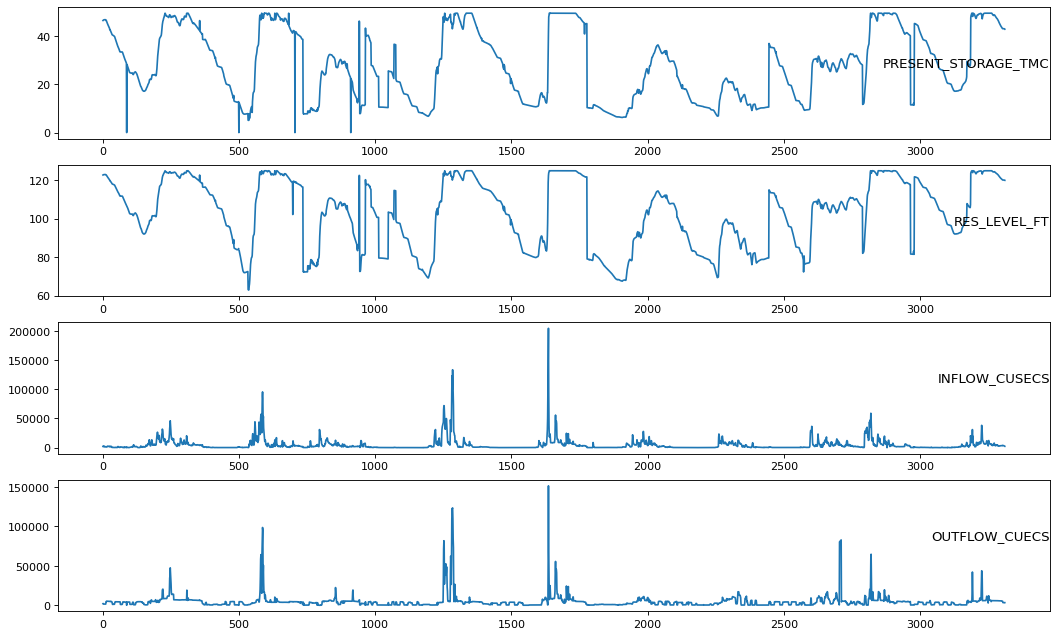

In [ ]:
# load dataset
dataset = pd.read_csv('/content/cloned-repo/KRS.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3]
i = 1
# plot each column
plt.figure(figsize=(16, 10), dpi=80)
for group in groups:
	plt.subplot(len(groups), 1, i)
	plt.plot(values[:, group])
	plt.title(dataset.columns[group], y=0.5, loc='right')
	i += 1
plt.show()

## **Univariate**

In [ ]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

In [ ]:
# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [ ]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

In [ ]:
# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

In [ ]:
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = np.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

In [ ]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

In [ ]:
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

In [ ]:
# load dataset
uniData = pd.read_csv('/content/cloned-repo/KRS.csv', header=0, index_col=0)
# drop "PRESENT_STORAGE_FT", "INFLOW_CUSECS", "OUTFLOW_CUECS" for predicting RES_LEVEL_FT
# drop "RES_LEVEL_FT", "INFLOW_CUSECS", "OUTFLOW_CUECS" for predicting PRESENT_STORAGE_FT
uniData = uniData.drop(["RES_LEVEL_FT", "INFLOW_CUSECS", "OUTFLOW_CUECS"], axis = 1)
uniValues = uniData.values
uniValues = uniValues.astype('float32')

In [ ]:
# transform data to be stationary
diff_values = difference(uniValues, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
n_train_days = 365 * 8
train = supervised_values[:n_train_days]
test = supervised_values[n_train_days:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

In [ ]:
lstm_model = fit_lstm(train_scaled, 1, 3, 1)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[0.00406806],
       [0.00404809],
       [0.00405036],
       ...,
       [0.00445419],
       [0.00447231],
       [0.00448092]], dtype=float32)

In [ ]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(uniValues, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = uniValues[len(train) + i + 1]
	print('Day=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Day=1, Predicted=47.381237, Expected=47.060001
Day=2, Predicted=47.091583, Expected=46.779999
Day=3, Predicted=46.811493, Expected=46.500000
Day=4, Predicted=46.531456, Expected=46.230000
Day=5, Predicted=46.261189, Expected=45.950001
Day=6, Predicted=45.981312, Expected=45.660000
Day=7, Predicted=45.691616, Expected=45.380001
Day=8, Predicted=45.411510, Expected=45.110001
Day=9, Predicted=45.141216, Expected=44.830002
Day=10, Predicted=44.861324, Expected=44.560001
Day=11, Predicted=44.591129, Expected=44.279999
Day=12, Predicted=44.311279, Expected=44.029999
Day=13, Predicted=44.060612, Expected=43.770000
Day=14, Predicted=43.800549, Expected=43.520000
Day=15, Predicted=43.550266, Expected=43.259998
Day=16, Predicted=43.290379, Expected=43.259998
Day=17, Predicted=43.284046, Expected=42.750000
Day=18, Predicted=42.783657, Expected=42.439999
Day=19, Predicted=42.473183, Expected=42.139999
Day=20, Predicted=42.172745, Expected=41.869999
Day=21, Predicted=41.901798, Expected=41.580002
D

Test RMSE: 0.065


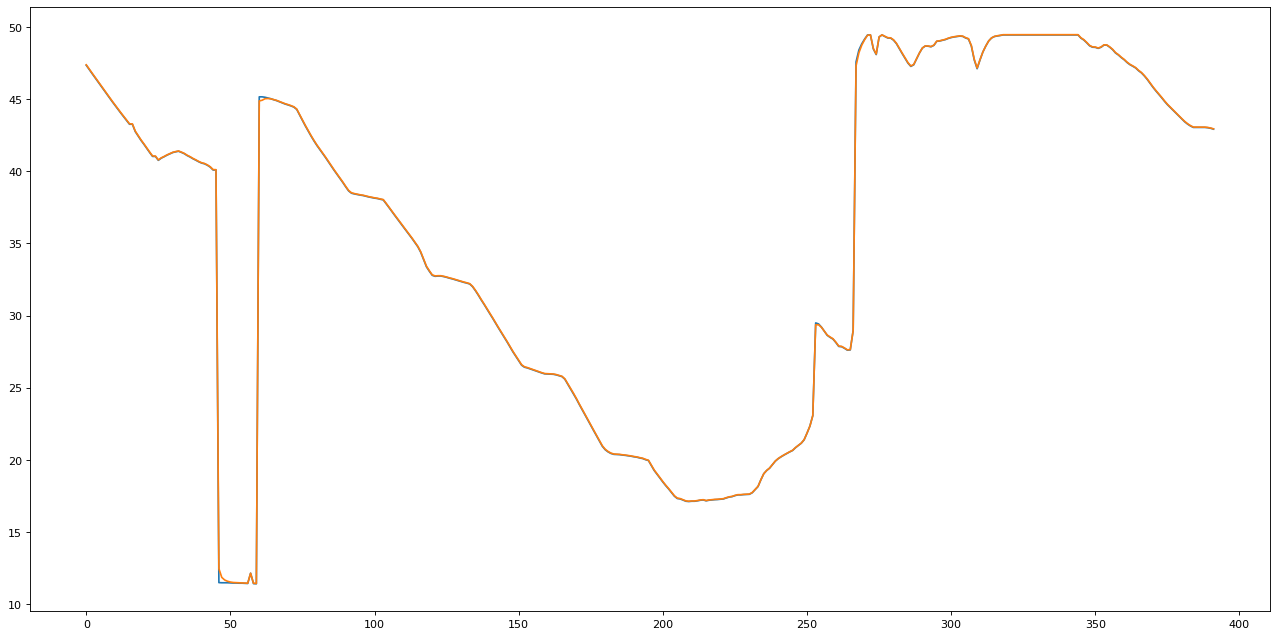

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(uniValues[n_train_days:-1], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
plt.figure(figsize=(20, 10), dpi=80)
plt.plot(uniValues[n_train_days:-1])
plt.plot(predictions)
plt.show()

## **Multivariate**

In [ ]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [ ]:
values

array([[  46.42,  122.59, 2029.  , 2000.  ],
       [  46.54,  122.68, 3084.  , 1490.  ],
       [  46.64,  122.75, 2776.  , 1491.  ],
       ...,
       [  42.98,  119.95, 3026.  , 3273.  ],
       [  42.92,  119.9 , 2530.  , 3068.  ],
       [  42.83,  119.83, 2416.  , 3243.  ]])

In [ ]:
# load dataset
dataset = pd.read_csv('/content/cloned-repo/KRS.csv', header=0, index_col=0)
values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1) 
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
1,0.938726,0.964355,0.009936,0.013213,0.941153,0.965806,0.015103,0.009844
2,0.941153,0.965806,0.015103,0.009844,0.943175,0.966935,0.013595,0.009850
3,0.943175,0.966935,0.013595,0.009850,0.944186,0.967581,0.011317,0.009850
4,0.944186,0.967581,0.011317,0.009850,0.944388,0.967742,0.009045,0.009850
5,0.944388,0.967742,0.009045,0.009850,0.945197,0.968226,0.010558,0.009850


In [ ]:
# drop columns we don't want to predict i.e, variables for the day to be predicted (t) are removed.
# predicting for col1 i.e, PRESENT_STORAGE_TMC drop 5,6,7
# predicting for col2 i.e, RES_LEVEL_FT drop 4,6,7
reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.938726   0.964355   0.009936   0.013213  0.941153
2   0.941153   0.965806   0.015103   0.009844  0.943175
3   0.943175   0.966935   0.013595   0.009850  0.944186
4   0.944186   0.967581   0.011317   0.009850  0.944388
5   0.944388   0.967742   0.009045   0.009850  0.945197


In [ ]:
# split into train and test sets
values = reframed.values
n_train_years = 365 * 8
train = values[:n_train_years, :]
test = values[n_train_years:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2920, 1, 4) (2920,) (390, 1, 4) (390,)


Epoch 1/50
41/41 - 4s - loss: 0.4164 - val_loss: 0.3871
Epoch 2/50
41/41 - 0s - loss: 0.1826 - val_loss: 0.1409
Epoch 3/50
41/41 - 0s - loss: 0.1131 - val_loss: 0.1094
Epoch 4/50
41/41 - 0s - loss: 0.0903 - val_loss: 0.0920
Epoch 5/50
41/41 - 0s - loss: 0.0705 - val_loss: 0.0756
Epoch 6/50
41/41 - 0s - loss: 0.0509 - val_loss: 0.0585
Epoch 7/50
41/41 - 0s - loss: 0.0311 - val_loss: 0.0330
Epoch 8/50
41/41 - 0s - loss: 0.0222 - val_loss: 0.0229
Epoch 9/50
41/41 - 0s - loss: 0.0197 - val_loss: 0.0193
Epoch 10/50
41/41 - 0s - loss: 0.0187 - val_loss: 0.0176
Epoch 11/50
41/41 - 0s - loss: 0.0182 - val_loss: 0.0144
Epoch 12/50
41/41 - 0s - loss: 0.0165 - val_loss: 0.0159
Epoch 13/50
41/41 - 0s - loss: 0.0175 - val_loss: 0.0154
Epoch 14/50
41/41 - 0s - loss: 0.0158 - val_loss: 0.0156
Epoch 15/50
41/41 - 0s - loss: 0.0159 - val_loss: 0.0173
Epoch 16/50
41/41 - 0s - loss: 0.0155 - val_loss: 0.0151
Epoch 17/50
41/41 - 0s - loss: 0.0136 - val_loss: 0.0129
Epoch 18/50
41/41 - 0s - loss: 0.0130 - 

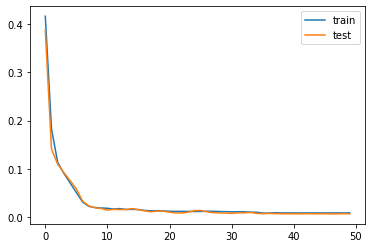

In [ ]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 2.426
